In [1]:
import Storm.victor_functions as victor_functions
from Storm.StormForcast import Train_Validate
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import os
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

#from google.colab import drive
#drive.mount('/content/gdrive/')

No GPU available! Running on CPU


In [3]:
input_channels = 1
hidden_channels = 128
output_channels = 1
kernel_size = 1
sequence_length = 5
num_epochs = 10
batch_size = 64
test_batch_size = 1000
seed = '6'

In [4]:
image_data = victor_functions.ImageDataset('./Selected_Storms_curated/', folder='bkh')
train_data, test_data = train_test_split(image_data)
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(test_data, batch_size= test_batch_size, shuffle=False, num_workers=0)
image_model = victor_functions.Seq2SeqAutoencoder(input_channels=input_channels, hidden_channels=hidden_channels, output_channels=output_channels, kernel_size=kernel_size)
# we are using pretrained models in this notebook but would use this class to train the autoencoder
# image_train = victor_functions.AutoencoderTrainer(image_model, train_loader, validation_loader, input_channels=input_channels, hidden_channels=hidden_channels, output_channels=output_channels, kernel_size=kernel_size, num_epochs=num_epochs)
# image_train.train_model()

In [5]:
# use pretrained model weights
# the weights can be found at https://drive.google.com/file/d/1x-_ujCB0lSoj_S3ICInrYNf6B7-OQRL_/view?usp=drive_link
image_model.load_state_dict(torch.load('seq2seq.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [6]:
# load images
image_directory = "./Surprise_Storm/tst/"

# Get all .jpg files in the directory
image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('.jpg')]

image_files.sort()

# Get the last four images
last_four_images = image_files[-4:]

print("Last four images:", last_four_images)

Last four images: ['./Surprise_Storm/tst/tst_251.jpg', './Surprise_Storm/tst/tst_252.jpg', './Surprise_Storm/tst/tst_253.jpg', './Surprise_Storm/tst/tst_254.jpg']


In [7]:
# load and transform the last four images
images = []
for img_path in last_four_images:
  img = Image.open(img_path).convert('L')
  transform = transforms.Compose([
      transforms.Resize((336, 336)),
      transforms.ToTensor()
      ])
  img = transform(img)
  images.append(img)

last_tensors = torch.stack(images).unsqueeze(0)
last_three = torch.stack(images[-3:]).unsqueeze(0)
last_two = torch.stack(images[-2:]).unsqueeze(0)

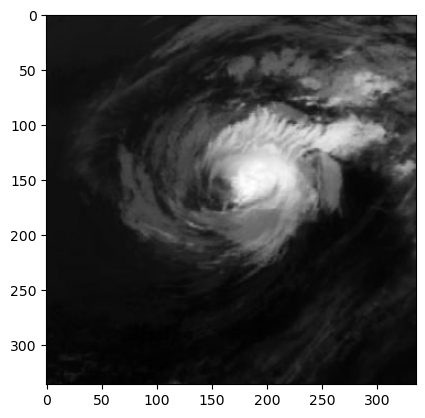

In [8]:
image_model.eval()
image_model.to(device)

with torch.no_grad():
    last_tensors = last_tensors.to(device)
    prediction_1 = image_model(last_tensors)

plt.imshow(prediction_1.squeeze().cpu().detach().numpy(), cmap='gray')

In [9]:
last_three = last_three.to(device)
last_two = last_two.to(device)
# Concatenate along the second dimension (dimension index 1)
last_tensors_2 = torch.cat((last_three, prediction_1), dim=1)
with torch.no_grad():
    last_tensors_2 = last_tensors_2.to(device)
    prediction_2 = image_model(last_tensors_2)
    last_tensors_3 = torch.cat((last_two, prediction_1, prediction_2), dim=1)
with torch.no_grad():
    last_tensors_3 = last_tensors_3.to(device)
    prediction_3 = image_model(last_tensors_3)

In [10]:
# create a function for saving images
def save_tensor(tensor, i):
    tensor = tensor.squeeze()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

    # Ensure tensor is of type float32 for saving
    tensor = tensor.type(torch.FloatTensor)

    # Save the tensor as an image
    save_image(tensor, f'./Surprise_Storm/tst/tst_{i+251}.jpg')

    # Plotting the image
    plt.imshow(tensor.cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

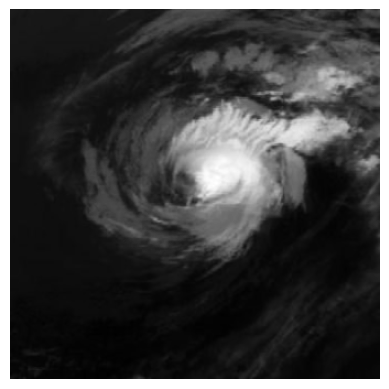

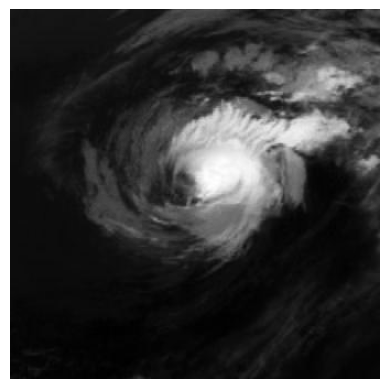

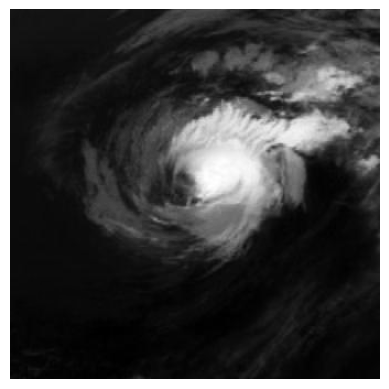

In [11]:
# save predicted images
save_tensor(prediction_1, 1)
save_tensor(prediction_2, 2)
save_tensor(prediction_3, 3)

In [12]:
# create train and test datasets for wind-speed prediction
train_dataset = victor_functions.Storm_Dataset('./Surprise_Storm/tst', split='train')
test_dataset = victor_functions.Storm_Dataset('./Surprise_Storm/tst', split='test')
# full dataset to plot the evolutiongn of windspeed over time
data = victor_functions.Storm_Dataset('./Surprise_Storm/tst')

# create dataloaders and model
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(test_dataset, batch_size= test_batch_size, shuffle=False, num_workers=0)
speed_predictor = victor_functions.ImageRegressionCNN()
# similarly to the previous model we a using a pretrained version but this would be how we would train the model
# speed_trainer = victor_functions.ImageRegressionTrainer(speed_predictor, train_loader, validation_loader, device, seed, num_epochs, 'CNNGeneral_040.pth')
# speed_trainer.train_model()

setting basic parameters ......
done
setting hyperparameters ......
done
initializing model, optimier, criterion ......
done
resuming previous model ......
done
loading data ......


Loading Data:  84%|████████▎ | 255/305 [00:00<00:00, 22992.12it/s]

done



/Users/christopher/opt/anaconda3/envs/dsml4p/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[61.40590286254883, 59.530418395996094, 57.64370346069336, 56.132694244384766, 57.29751205444336, 57.99265670776367, 57.52058029174805, 56.12922668457031, 53.325992584228516, 52.22770309448242, 60.26641082763672, 63.08329772949219, 64.56002807617188]


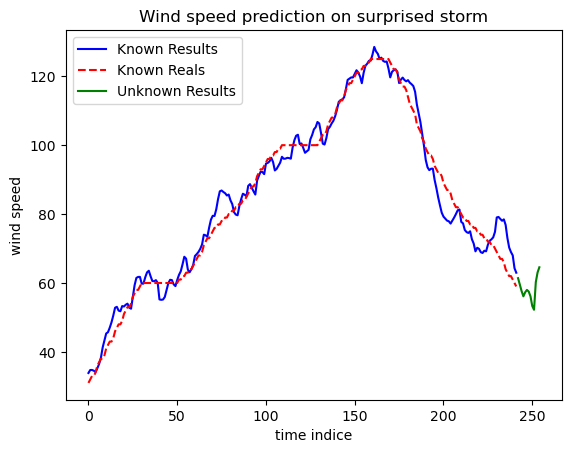

In [13]:
# load model weights
# weights can be found at https://drive.google.com/file/d/1iFJV7HI3YpWDgF4tOibXoEfCqeQwZkyw/view?usp=drive_link
surprise_model = Train_Validate('./Surprise_Storm/tst/', task='WindSpeed', device='cpu', batch_size_train=135, batch_size_val=100, batch_size_test=100, lr=2e-11, epoch=30, weight_decay=1e-1, split_method='random', num_storms=1, surprise_storm=True, resume=True, resume_path='CNNGeneral_epoch_13__2024-02-02_06-07-09.pth')
surprise_model.draw_result(type='predict')
 

In [14]:
# predict the wind-speed for latest values
times = []
labels= []
speeds = surprise_model.predict()
for i in range(13):
    index = 13-i
    image, l, t = data[-index]
    labels.append(l)
    times.append(t)



In [15]:
data = {'time': times, 'speed': speeds}
df = pd.DataFrame(data)

In [16]:
df.to_csv('predictions.csv', header=False, index=False)